Rainfall Prediction is one of the difficult and uncertain tasks that have a significant impact on human society. Timely and accurate forecasting can proactively help reduce human and financial loss. This study presents a set of experiments that involve the use of common machine learning techniques to create models that can predict whether it will rain tomorrow or not based on the weather data for that day in major cities in Australia.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    cohen_kappa_score,
    roc_curve,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import catboost as cb


# Load Dataset

In [2]:
data = pd.read_csv("weatherAUS.csv")

data["Date"] = pd.to_datetime(data["Date"])
data["year"] = data["Date"].dt.year
data["month"] = data["Date"].dt.month
data["day"] = data["Date"].dt.day
data.drop("Date", axis=1, inplace=True)

data["RainToday"] = data["RainToday"].map({"No": 0, "Yes": 1})
data["RainTomorrow"] = data["RainTomorrow"].map({"No": 0, "Yes": 1})

data.head()


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,2008,12,5


# Class Imbalance Visualization

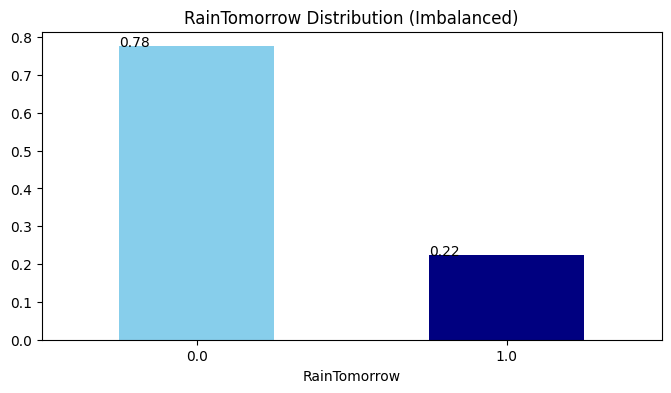

In [3]:
plt.figure(figsize=(8, 4))
ax = data["RainTomorrow"].value_counts(normalize=True).plot(
    kind="bar", color=["skyblue", "navy"], rot=0
)
plt.title("RainTomorrow Distribution (Imbalanced)")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x(), p.get_height()))
plt.show()


# Oversampling (Balancing Dataset)

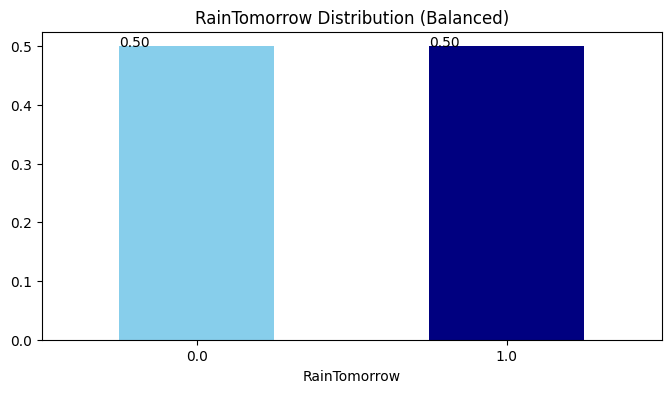

In [4]:
no = data[data.RainTomorrow == 0]
yes = data[data.RainTomorrow == 1]

yes_over = resample(yes, replace=True, n_samples=len(no), random_state=42)
oversampled = pd.concat([no, yes_over])

plt.figure(figsize=(8, 4))
ax = oversampled["RainTomorrow"].value_counts(normalize=True).plot(
    kind="bar", color=["skyblue", "navy"], rot=0
)
plt.title("RainTomorrow Distribution (Balanced)")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x(), p.get_height()))
plt.show()


# Missing Data Heatmap

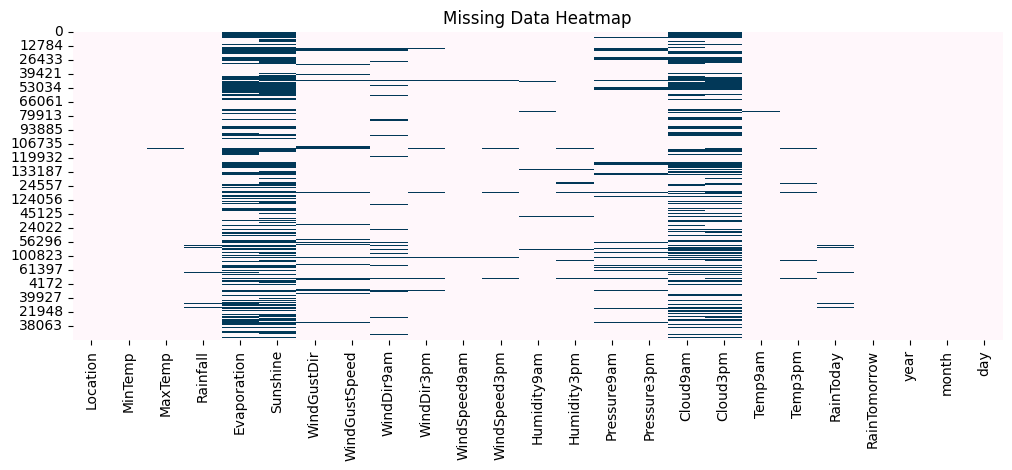

In [5]:
plt.figure(figsize=(12, 4))
sns.heatmap(oversampled.isnull(), cbar=False, cmap="PuBu")
plt.title("Missing Data Heatmap")
plt.show()


# Categorical Imputation & Encoding

In [6]:
cat_cols = oversampled.select_dtypes(include="object").columns

for col in cat_cols:
    oversampled[col].fillna(oversampled[col].mode()[0], inplace=True)

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    oversampled[col] = le.fit_transform(oversampled[col])
    label_encoders[col] = le

oversampled.head()


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,14,...,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,2008,12,1
1,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,15,...,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,2008,12,2
2,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,15,...,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,2008,12,3
3,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,0,...,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,2008,12,4
4,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,7,...,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,2008,12,5


# MICE Imputation

In [7]:
mice = IterativeImputer(random_state=42)
mice_data = pd.DataFrame(
    mice.fit_transform(oversampled),
    columns=oversampled.columns
)

mice_data.head()


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,2.0,13.4,22.9,0.6,6.072801,7.661663,13.0,44.0,13.0,14.0,...,1007.1,8.000000,4.762100,16.9,21.8,0.0,0.0,2008.0,12.0,1.0
1,2.0,7.4,25.1,0.0,5.970257,11.646092,14.0,44.0,6.0,15.0,...,1007.8,1.881555,2.602510,17.2,24.3,0.0,0.0,2008.0,12.0,2.0
2,2.0,12.9,25.7,0.0,8.061939,12.455989,15.0,46.0,13.0,15.0,...,1008.7,1.976858,2.000000,21.0,23.2,0.0,0.0,2008.0,12.0,3.0
3,2.0,9.2,28.0,0.0,6.289679,11.937781,4.0,24.0,9.0,0.0,...,1012.8,1.366446,2.101293,18.1,26.5,0.0,0.0,2008.0,12.0,4.0
4,2.0,17.5,32.3,1.0,7.392235,6.140667,13.0,41.0,1.0,7.0,...,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.0,2008.0,12.0,5.0


# Outlier Removal (IQR)

In [8]:
Q1 = mice_data.quantile(0.25)
Q3 = mice_data.quantile(0.75)
IQR = Q3 - Q1

mice_data = mice_data[
    ~((mice_data < (Q1 - 1.5 * IQR)) |
      (mice_data > (Q3 + 1.5 * IQR))).any(axis=1)
]

mice_data.shape


(170401, 25)

# Correlation Heatmap

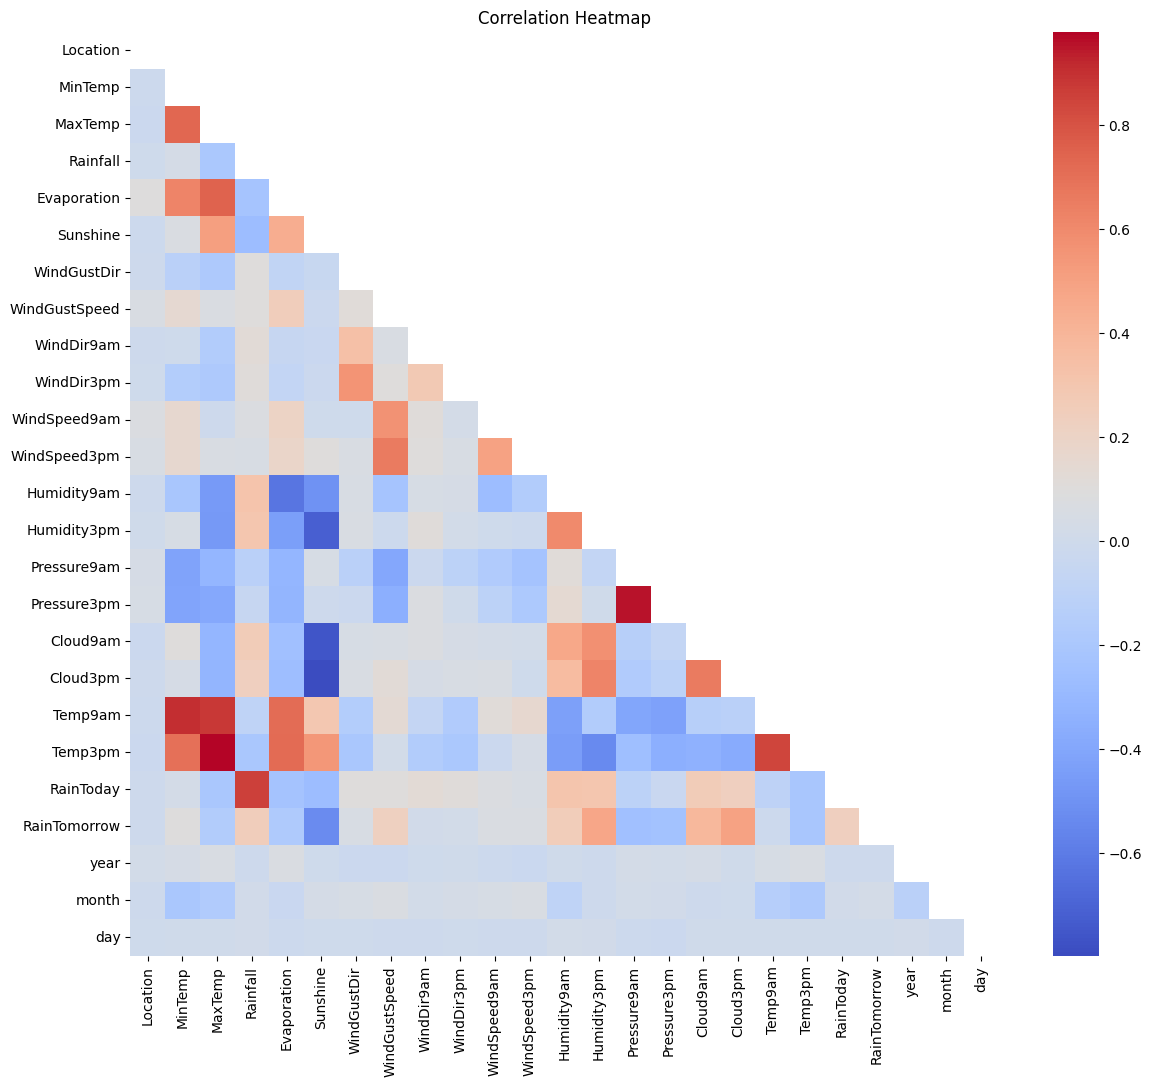

In [9]:
plt.figure(figsize=(14, 12))
corr = mice_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# Feature Selection (Chi-Square)

In [10]:
scaler_mm = MinMaxScaler()
scaled = pd.DataFrame(
    scaler_mm.fit_transform(mice_data),
    columns=mice_data.columns
)

X_fs = scaled.drop("RainTomorrow", axis=1)
y_fs = scaled["RainTomorrow"]

selector = SelectKBest(chi2, k=10)
selector.fit(X_fs, y_fs)

X_fs.columns[selector.get_support()]


Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')

# Train/Test Split & Scaling

In [11]:
X = mice_data.drop("RainTomorrow", axis=1)
y = mice_data["RainTomorrow"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Evaluation Function

In [12]:
def run_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))

    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

    return acc, auc, kappa


# Train Models


Logistic Regression
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82     19120
         1.0       0.78      0.74      0.76     14961

    accuracy                           0.79     34081
   macro avg       0.79      0.79      0.79     34081
weighted avg       0.79      0.79      0.79     34081



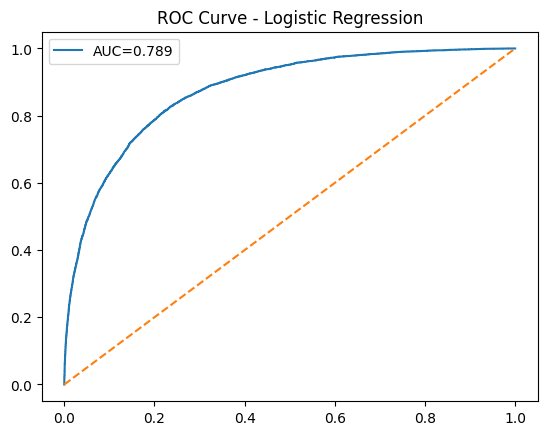


Decision Tree
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     19120
         1.0       0.86      0.94      0.90     14961

    accuracy                           0.90     34081
   macro avg       0.90      0.91      0.90     34081
weighted avg       0.91      0.90      0.90     34081



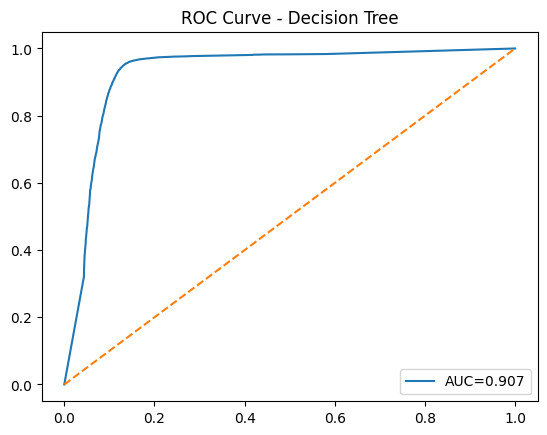


Neural Network
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91     19120
         1.0       0.88      0.89      0.88     14961

    accuracy                           0.90     34081
   macro avg       0.89      0.90      0.90     34081
weighted avg       0.90      0.90      0.90     34081



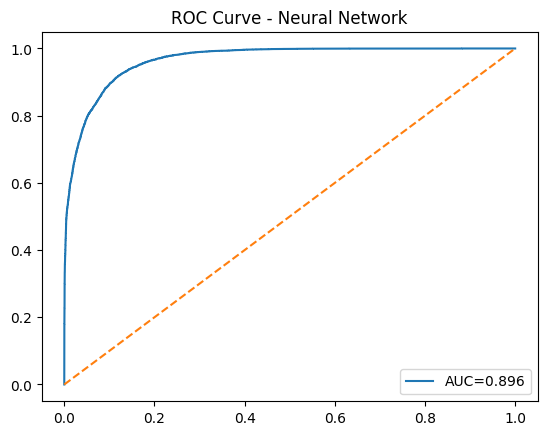


Random Forest
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     19120
         1.0       0.90      0.95      0.93     14961

    accuracy                           0.93     34081
   macro avg       0.93      0.94      0.93     34081
weighted avg       0.93      0.93      0.93     34081



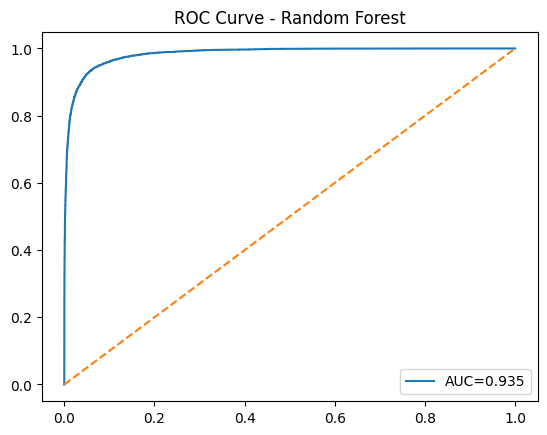


CatBoost
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87     19120
         1.0       0.84      0.82      0.83     14961

    accuracy                           0.85     34081
   macro avg       0.85      0.85      0.85     34081
weighted avg       0.85      0.85      0.85     34081



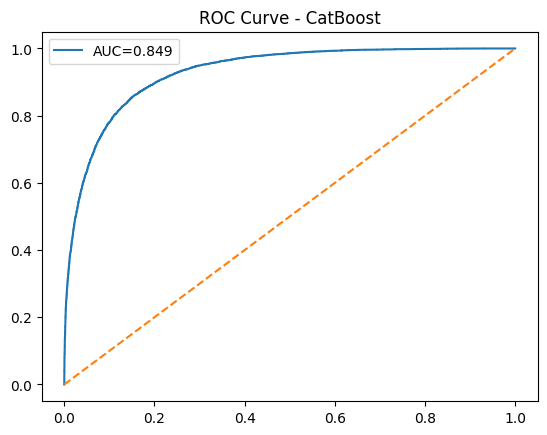

,Model,Accuracy,ROC_AUC,Cohen_Kappa
0,Logistic Regression,0.794871,0.788822,0.581070
1,Decision Tree,0.903583,0.907337,0.806270
2,Neural Network,0.896658,0.895743,0.790463
3,Random Forest,0.933247,0.935113,0.865251
4,CatBoost,0.851882,0.848953,0.698870


In [13]:
models = {
    "Logistic Regression": LogisticRegression(penalty="l1", solver="liblinear"),
    "Decision Tree": DecisionTreeClassifier(max_depth=16),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(30,30,30), max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=16),
    "CatBoost": cb.CatBoostClassifier(iterations=50, verbose=0)
}

results = []

for name, model in models.items():
    results.append((name, *run_model(model, name)))

results_df = pd.DataFrame(
    results, columns=["Model", "Accuracy", "ROC_AUC", "Cohen_Kappa"]
)

results_df


# Model Comparison Plots

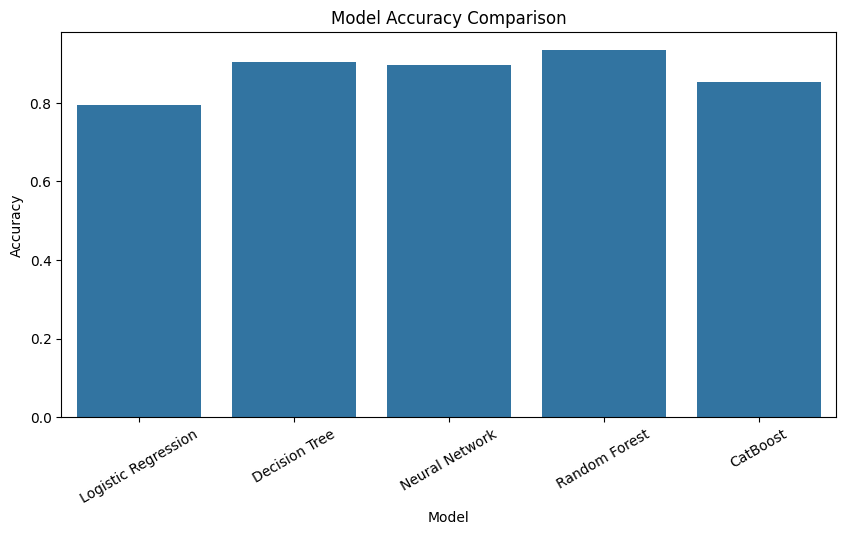

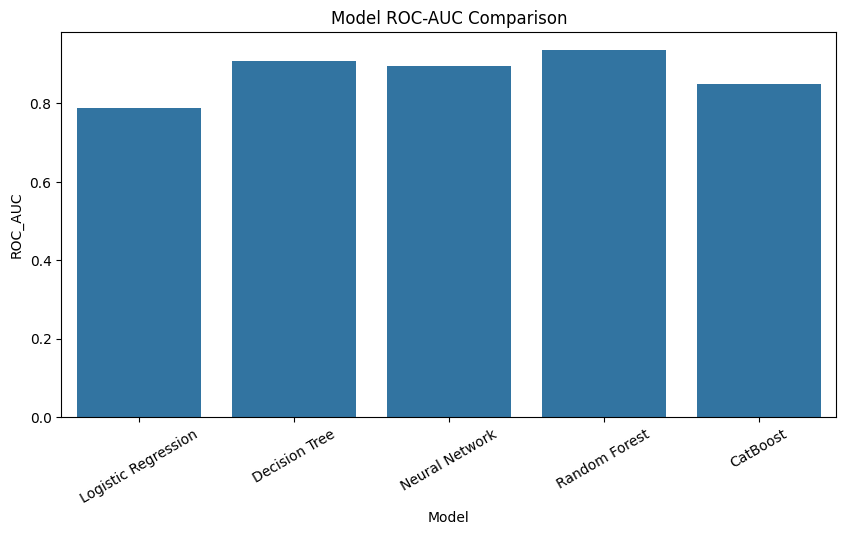

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.xticks(rotation=30)
plt.title("Model Accuracy Comparison")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="ROC_AUC", data=results_df)
plt.xticks(rotation=30)
plt.title("Model ROC-AUC Comparison")
plt.show()
